## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [3]:
import numpy as np
import math
import pandas as pd
import re
import ssl
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import csv
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings("ignore")

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [7]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/nikhilg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhilg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nikhilg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nikhilg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [4]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [5]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [6]:
df.sentiment.value_counts()

positive    12474
negative    12225
Name: sentiment, dtype: int64

## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

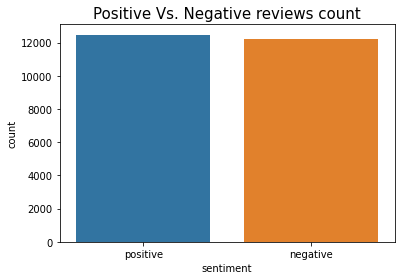

In [7]:
plt.figure(figsize = None)
sns.countplot(x ='sentiment', data = df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [8]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([negative_upsample, df_majority])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [9]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled.sentiment == 'negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [10]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled.sentiment == 'positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [12]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[(df_upsampled["sentiment"]=='negative')].iloc[:10000]                                   
positive_data_points_train = df_upsampled[(df_upsampled["sentiment"]=='positive')].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[(df_upsampled["sentiment"]=="negative")].iloc[10000:]
positive_data_points_test = df_upsampled[(df_upsampled["sentiment"]=="positive")].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])

In [13]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [14]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [15]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()

In [16]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    words= review.lower()
    words= re.sub(r'https?://\S+','',words)
    words= re.sub(r'[^\w\s]','',words)
    words= word_tokenize(words)
    reviews=[word for word in words if word not in stopwords.words('english')]
    # review_cleaned = [ps.stem(word) for word in reviews]
    review_cleaned = [lemma.lemmatize(word) for word in reviews]
    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [17]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0
    combo = (word, label)
    if combo in frequency:
        n = frequency[combo]
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [18]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [19]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [20]:
## Choosing a random review and taking a look at it.
X_train.iloc[4]

'Oh yeah, this one is definitely a strong contender to win the questionable award of "worst 80\'s slasher ever made". "The Prey" has got everything you usually want to avoid in a horror flick: a routine, derivative plot that you\'ve seen a thousand times before (and better), insufferable characters and terrible performances, a complete lack of gore and suspense, fuzzy photography and unoriginal locations and Â\x96 most irritating of all Â\x96 the largest amount of pointless padding footage you\'ve ever encountered in your life (and that\'s not an exaggeration but a guarantee!). Apart from the seemingly endless amount of National Geographic stock footage, which I\'ll expand upon later, this film is shameless enough to include a complete banjo interlude (!) and two occasions where characters tell dillydally jokes that aren\'t even remotely funny! The set-up is as rudimentary as it gets, with the intro showing images of a devastating forest fire with OTT voice-over human screams. Fast for

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [21]:
custom_review = X_train.iloc[4]

# print cleaned review
print(clean_review(custom_review))

['oh', 'yeah', 'one', 'definitely', 'strong', 'contender', 'win', 'questionable', 'award', 'worst', '80', 'slasher', 'ever', 'made', 'prey', 'got', 'everything', 'usually', 'want', 'avoid', 'horror', 'flick', 'routine', 'derivative', 'plot', 'youve', 'seen', 'thousand', 'time', 'better', 'insufferable', 'character', 'terrible', 'performance', 'complete', 'lack', 'gore', 'suspense', 'fuzzy', 'photography', 'unoriginal', 'location', 'â', 'irritating', 'â', 'largest', 'amount', 'pointless', 'padding', 'footage', 'youve', 'ever', 'encountered', 'life', 'thats', 'exaggeration', 'guarantee', 'apart', 'seemingly', 'endless', 'amount', 'national', 'geographic', 'stock', 'footage', 'ill', 'expand', 'upon', 'later', 'film', 'shameless', 'enough', 'include', 'complete', 'banjo', 'interlude', 'two', 'occasion', 'character', 'tell', 'dillydally', 'joke', 'arent', 'even', 'remotely', 'funny', 'setup', 'rudimentary', 'get', 'intro', 'showing', 'image', 'devastating', 'forest', 'fire', 'ott', 'voiceov

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [32]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review)
      for word in split_review:
        word_list= (word,label)
        if word_list not in output_occurrence:
            output_occurrence[(word, label)] = 1
        else:
            output_occurrence[(word, label)] += 1
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [33]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [34]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [35]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('scenery', 1): 189,
 ('pretty', 1): 1631,
 ('dog', 1): 360,
 ('cute', 1): 203,
 ('film', 1): 16644,
 ('absolutely', 1): 728,
 ('nothing', 1): 2344,
 ('recommend', 1): 540,
 ('jack', 1): 306,
 ('warden', 1): 27,
 ('pleasantly', 1): 16,
 ('genial', 1): 3,
 ('usual', 1): 306,
 ('script', 1): 1717,
 ('awful', 1): 1116,
 ('even', 1): 6166,
 ('come', 1): 2117,
 ('badly', 1): 389,
 ('plot', 1): 3286,
 ('make', 1): 5085,
 ('sense', 1): 899,
 ('dialogue', 1): 824,
 ('dumb', 1): 442,
 ('numerous', 1): 131,
 ('smaller', 1): 30,
 ('fault', 1): 147,
 ('trio', 1): 43,
 ('treasure', 1): 63,
 ('hunter', 1): 140,
 ('searching', 1): 50,
 ('west', 1): 150,
 ('indie', 1): 86,
 ('hidden', 1): 90,
 ('fortune', 1): 66,
 ('lure', 1): 28,
 ('gold', 1): 128,
 ('rise', 1): 112,
 ('tension', 1): 204,
 ('men', 1): 643,
 ('closer', 1): 46,
 ('location', 1): 262,
 ('deepsea', 1): 3,
 ('diver', 1): 15,
 ('hope', 1): 612,
 ('track', 1): 204,
 ('find', 1): 1779,
 ('greed', 1): 23,
 ('hatred', 1): 39,
 ('lead', 1): 79

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [37]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = {}
    for (word, label) in list(freqs.keys()):
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = 0
    for label in train_y:
        if label == 1:
            pos_num_docs += 1

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = 0
    for label in y_train:
        if label == 0 :
            neg_num_docs += 1

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(num_pos + V)
        p_w_neg = (freq_neg + 1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)


    return logprior, loglikelihood

In [38]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
92360


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [40]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
    
    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0

    return total_prob

In [41]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [76]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hats.append(1)
        else:
            # otherwise the predicted class is 0
            y_hats.append(0)

        # append the predicted class to the list y_hats
        #y_hats = None

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))

    accuracy = 1 - error


    return accuracy

In [44]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [45]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [46]:
def random_split():
  x=df.review
  y=df.sentiment
  x_train1,x_test1,y_train1,y_test1=train_test_split(x,y,test_size=0.25,random_state=12)
  return x_train1,x_test1,y_train1,y_test1

In [47]:
x_train1,x_test1,y_train1,y_test1 = random_split()

In [48]:
output_map = {'positive': 0, 'negative': 1}
y_train1 = y_train1.map(output_map)
y_test1 = y_test1.map(output_map)

In [49]:
freqs1 = review_counter({}, x_train1, y_train1)
freqs1

{('believe', 0): 773,
 ('sarafina', 0): 8,
 ('tremendous', 0): 81,
 ('effort', 0): 284,
 ('whoopi', 0): 26,
 ('goldberg', 0): 30,
 ('besides', 0): 135,
 ('star', 0): 1269,
 ('film', 0): 17904,
 ('role', 0): 1706,
 ('smaller', 0): 48,
 ('title', 0): 543,
 ('character', 0): 5036,
 ('since', 0): 1094,
 ('work', 0): 2099,
 ('high', 0): 680,
 ('school', 0): 582,
 ('urban', 0): 73,
 ('child', 0): 1076,
 ('think', 0): 2822,
 ('important', 0): 444,
 ('show', 0): 3540,
 ('south', 0): 199,
 ('african', 0): 85,
 ('history', 0): 582,
 ('apartheid', 0): 15,
 ('movie', 0): 16140,
 ('education', 0): 44,
 ('teacher', 0): 135,
 ('relationship', 0): 671,
 ('student', 0): 252,
 ('bought', 0): 151,
 ('video', 0): 514,
 ('practically', 0): 68,
 ('nothing', 0): 940,
 ('videostore', 0): 3,
 ('watched', 0): 823,
 ('fast', 0): 219,
 ('forwarded', 0): 2,
 ('musical', 0): 484,
 ('number', 0): 525,
 ('strongly', 0): 123,
 ('recommend', 0): 789,
 ('educator', 0): 3,
 ('understand', 0): 613,
 ('dont', 0): 2449,
 ('

In [50]:
#2. Calculating model parameter
logprior1, loglikelihood1 = train_naive_bayes(freqs1, x_train1, y_train1)
print(logprior1)
print(len(loglikelihood1))

-0.08425155244759175
96932


In [89]:
def confusionMatrix(train_x, train_y, logprior, loglikelihood):
  TP=TN=FN=FP=0
  i=0
  for i in range(len(train_x)):
    review=train_x.iloc[i]
    prediction = naive_bayes_predict(review, logprior, loglikelihood)
    if (prediction == train_y.iloc[i] and prediction== 0) :
      TP +=1
    elif (prediction == train_y.iloc[i] and prediction== 1) :
      TN +=1
    elif (prediction != train_y.iloc[i] and prediction== 1) :
      FN +=1
    elif (prediction != train_y.iloc[i] and prediction== 0) :
      FP +=1
  print("True Positives:", TP)
  print("True Negatives:", TN)
  print("False Positives:", FP)
  print("False Negatives:", FN)
  confusion_matix = pd.DataFrame({'Negative':[TN,FN],'Positive':[FP,TP]})
  confusion_matix.index = ['Negative', 'Postive']
  accuracy = (TP+TN)/(TP+TN+FP+FN)
  return accuracy,confusion_matix



In [53]:
#3. Finding Confusion Matrix

accuracy_train, confusion_matrix = confusionMatrix(x_train1, y_train1, logprior1, loglikelihood1)
print(confusion_matrix)
print("Train Set Accuracy",accuracy_train)


True Positives: 8505
True Negatives: 8767
False Positives: 425
False Negatives: 827
          Negative  Positive
Negative      8767       425
Postive        827      8505
Train Set Accuracy 0.9324120060462103


In [77]:
test_naive_bayes(x_train1,y_train1,logprior1,loglikelihood1)

0.9324120060462103

Text(0.5, 1.0, 'Training Set Confusion Matrix')

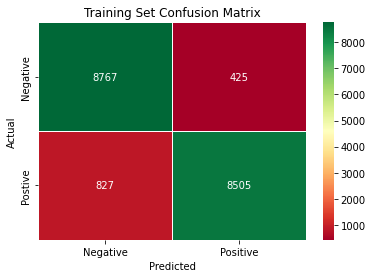

In [63]:
s= sns.heatmap(confusion_matrix, cmap ='RdYlGn', linewidths = 0.5, annot = True, fmt= 'g')
s.set(xlabel='Predicted', ylabel='Actual')
s.set_title('Training Set Confusion Matrix')

In [60]:
accuracy_test,confusion_matrix1 = confusionMatrix(x_test1, y_test1, logprior1, loglikelihood1)
print(confusion_matrix1)
print("Test Set Accuracy",accuracy_test)


True Positives: 2646
True Negatives: 2654
False Positives: 379
False Negatives: 496
          Negative  Positive
Negative      2654       379
Postive        496      2646
Test Set Accuracy 0.8582995951417004


In [79]:
test_naive_bayes(x_test1,y_test1,logprior1,loglikelihood1)

0.8582995951417004

Text(0.5, 1.0, 'Testing Set Confusion Matrix')

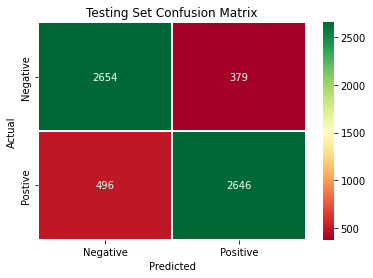

In [66]:
s1=sns.heatmap(confusion_matrix1, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='g')
s1.set(xlabel='Predicted', ylabel='Actual')
s1.set_title('Testing Set Confusion Matrix')

#4 Examining False classification

While training the model using the training data set there might be certain words that are used in a different context. These words while used as part of sentence take a different sentiment based on the context of the sentence. So here the training data has few such words that are classified as one sentiment but when the prediction is done on the test set the words were used in another context hence leading to a misclassification of the reviews.

So for example the word "star" was initially trained to be a word in a positive context, but when classifying a review the word might have been in context of a negative but it might have still been classified as a positive review because it might contain such words.

Also there might be new words as part of reviews which are part of the test data set but not part of the training data set. These may also contribute to the misclassification.

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [90]:
import pickle

pickle.dump([logprior1,loglikelihood1], open("output","wb"))

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

1. 
    Naive Bayes operations require Laplace or any other additive smoothing technique especially for text classification because the smoothing techniques aids in overcoming the zero probability problem.

    Naive Bayes algorithm is based on a test sequence 𝐱=(𝑥1,𝑥2,…,𝑥𝑛) using the following equation:

    y(𝑝𝑟𝑒𝑑) = argmax[ 𝑦𝑃(𝑦)𝑃(𝑥1|𝑦)𝑃(𝑥2|𝑦)…𝑃(𝑥𝑛|𝑦)]

    The probabilities in this equation are calculated by counting the number of times each event occurs in the training data.

    For example, while dealing with our review classification task using our training data set, if we encounter a word 'unfamiliar' only in negative reviews, and never in positive reviews then

    𝑃(unfamiliar|positive)=0

    This means that the word 'unfamiliar' will not appear in any of the positive reviews. Clearly, this is not the case. This event has a low likelihood, but it is clearly not zero. Furthermore, because we multiply all of the probabilities during the inference, even one such zero probability element will collapse the entire process.

    As a result, smoothing is required since the final goal is to boost the zero probability values to a tiny positive amount while reducing other values to keep the sum at 1.

2. 
    To predict a class, Naive Bayes Classification use the following hypothesis:

    𝑦(𝑝𝑟𝑒𝑑) = argmax [𝑦𝑃(𝑦)𝑃(𝑥1|𝑦)𝑃(𝑥2|𝑦)…𝑃(𝑥𝑛|𝑦)]

    We know that each P(xi|y) term has a value between 0 and 1, but when we add them together, the overall result approaches zero. This is increased by the addition of each additional feature: multiplying a large number of probabilities together produces an exceedingly small value, which is frequently unrepresentable in a double or long double. As a result, we represent probabilities as log-probabilities to solve this problem. Log-probabilities is always between −∞ and 0 and as a result it provide us a much wider range of numbers whereas in probability our result is always between 0 and 1. 
  
    The properties of log function such as :

    1) If a < b, then log a < log b

    2) log(a · b) = log a + log b

    Using the above, makes probability comparisons and calculations easier. Therefore, in Naive Bayes Algorithm, we compute logarithmic values instead of probability values.